In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('utils'))
import qiskit
from qiskit.result import marginal_counts
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector # to compute state vectors
from qiskit.visualization import array_to_latex
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator # ideal simulator backend
from qiskit.visualization import plot_histogram  # to plot histograms of simulation results
import numpy as np
from collections import namedtuple
from IPython.display import display, Markdown, Latex
import sympy as sp
from qiskit.circuit.library.standard_gates import XGate, ZGate
from qiskit.circuit.library import GroverOperator, MCMT

sys.path.insert(1, '../')
from utils import Helpers as hp

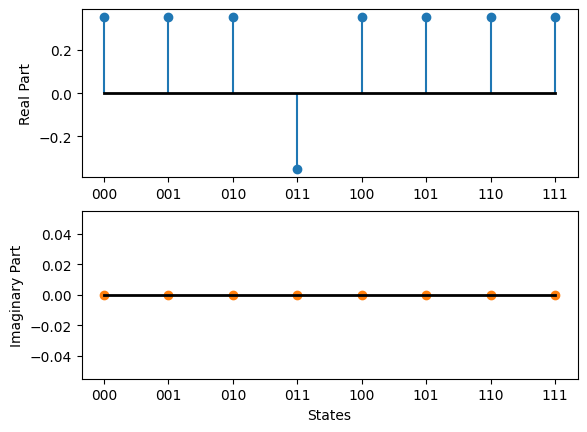

In [2]:
vals = np.repeat(1/np.sqrt(8), 8)
vals[3] = -1/np.sqrt(8)
input = Statevector(vals)
hp.plot_statevector(input, '')

In [35]:
def negate():
    n = QuantumCircuit(1)
    n.z(0)
    n.x(0)
    n.z(0)
    n.x(0)
    return n

qf = QuantumCircuit(3)
c = MCMT(negate(), 2, 1)
qf.append(c, [0, 1, 2])

# qf.decompose().draw('mpl')
hp.derive_unitary_matrix(c)

C:\Users\User\AppData\Local\Temp\ipykernel_6136\2599831627.py:10: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  c = MCMT(negate(), 2, 1)


<IPython.core.display.Latex object>

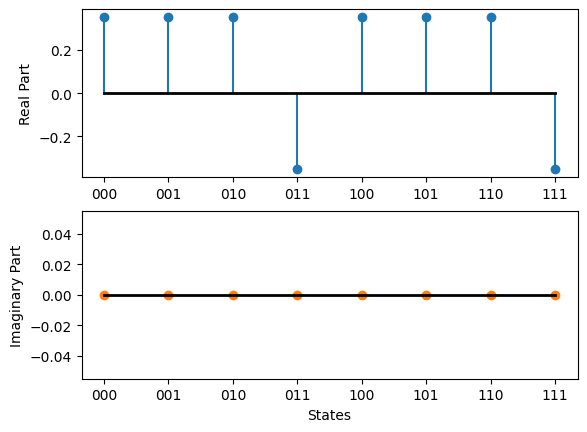

In [22]:
input = Statevector.from_label('+++').evolve(qf)
hp.plot_statevector(input, '')

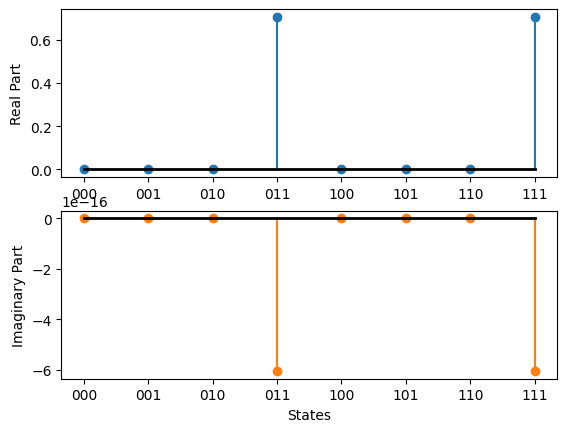

In [31]:
grover_op = GroverOperator(QuantumCircuit(3), insert_barriers=True)
hp.plot_statevector(input.evolve(grover_op), '')

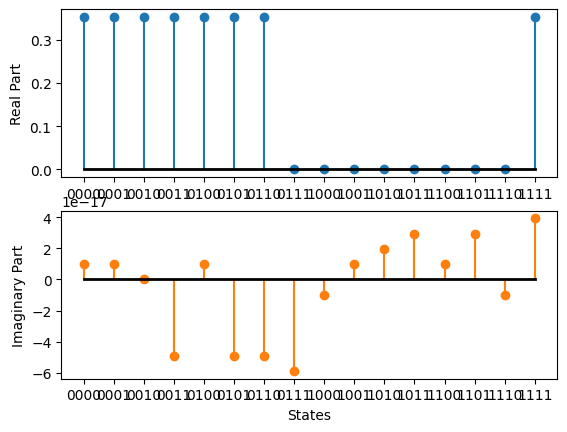

In [102]:
qf = QuantumCircuit(4)
qf.append(XGate().control(3), [0,1,2,3])

# qf.draw('mpl')
hp.plot_statevector(input.evolve(qf), '')

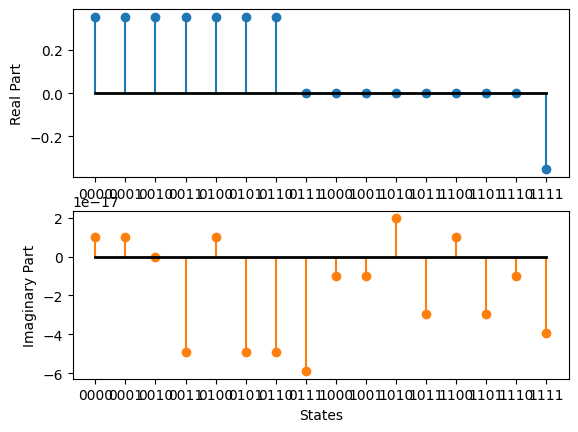

In [105]:
# Creates a circuit that negates the input ( |x> => -I|x> )
def negate(num_qubits: int):
    n = QuantumCircuit(num_qubits)
    n.z(0)
    n.x(0)
    n.z(0)
    n.x(0)
    return n

qc = QuantumCircuit(4)
qc.cz(3, 0)
# qc.decompose().draw('mpl')
hp.plot_statevector(input.evolve(qf).evolve(qc), '')

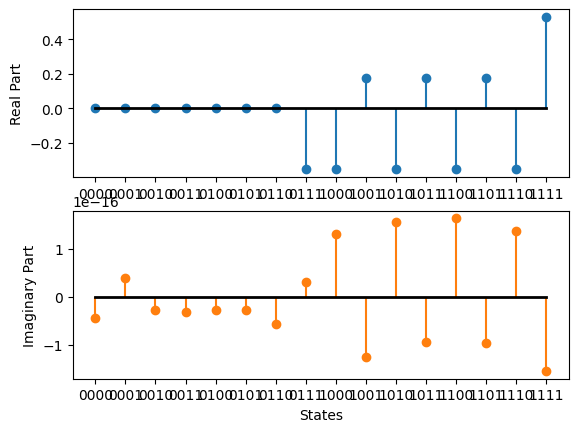

In [109]:
def grover():
    qc = QuantumCircuit(4)
    grover_op = GroverOperator(QuantumCircuit(4), insert_barriers=True)
    qc.append(grover_op, [0, 1, 2, 3])
    return qc

out = input.evolve(qf).evolve(qc).evolve(grover()).evolve(qc).evolve(grover())
# out = out.evolve(qc).evolve(grover())

hp.plot_statevector(out, '')

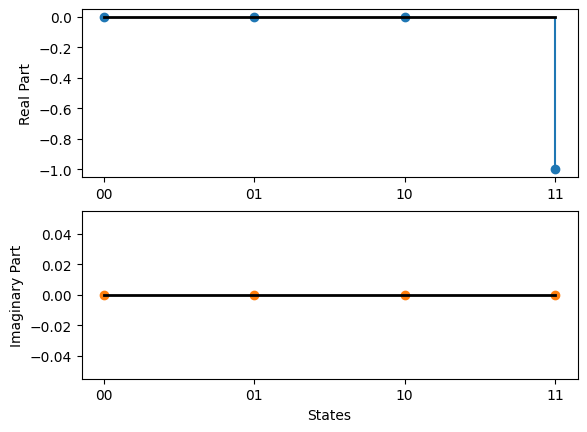

In [158]:
zz = QuantumCircuit(2)
zz.x(0)
zz.x(1)
zz.cz(0,1)

hp.plot_statevector(Statevector.from_label('00').evolve(zz), '')

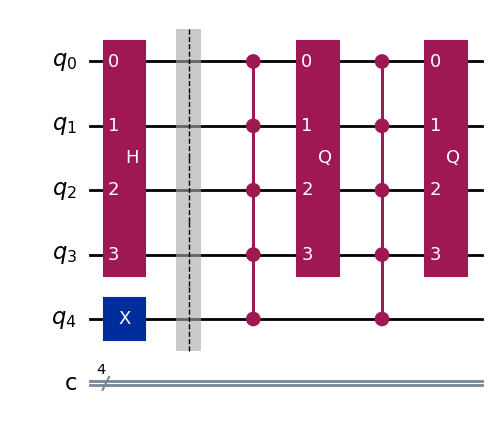

In [258]:
def h(n: int):
    h = QuantumCircuit(n, name='H')
    for i in range(n):
        h.h(i)
    return h

# # molto easy: setta l'ancilla a 1 se sono tutti 1, altrimenti e' 0
# def f(n: int):
#     qf = QuantumCircuit(n, name='Check Path')
#     qf.append(XGate().control(n-1), range(n))
#     return qf

# inverte dove l'ancilla e' 1
def u(n: int):
    def negate() -> QuantumCircuit:
        n = QuantumCircuit(1)
        n.z(0)
        n.x(0)
        n.z(0)
        n.x(0)
        return n
    qc = QuantumCircuit(n, name='Negate')
    qc.append(negate().control(1), [n-1, 0])
    return qc

def grover(n: int):
    return GroverOperator(QuantumCircuit(n), insert_barriers=True)

# Grover algorithm
# init
grover_qc = QuantumCircuit(5, 4)
grover_qc.append(h(4), range(4))
grover_qc.x(4)

grover_qc.barrier()
# conditions
grover_qc.append(ZGate().control(4), [0,1,2,3, 4])
grover_qc.append(grover(4), range(4))

grover_qc.append(ZGate().control(4), [0,1,2,3, 4])
grover_qc.append(grover(4), range(4))

# grover_qc.append(ZGate().control(4), [0,1,2,3,4])
# grover_qc.append(grover(4), range(4))

grover_qc.draw('mpl')

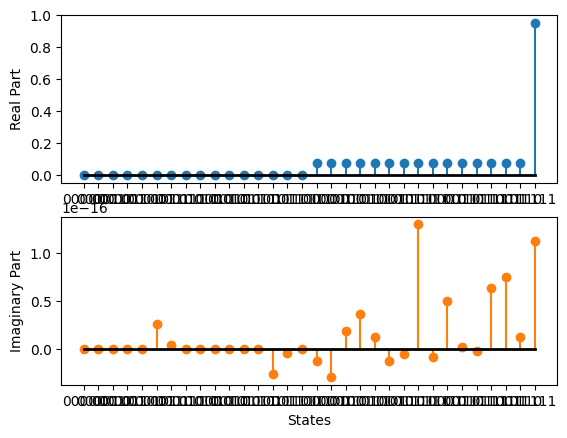

In [259]:
s = Statevector.from_label('00000')
hp.plot_statevector(s.evolve(grover_qc), '')

In [260]:
sim = AerSimulator()
N = 100
qc_transpiled = transpile(grover_qc, sim)
qc_transpiled.measure(range(4),range(4))
r = sim.run(qc_transpiled, shots=N).result().get_counts()

In [261]:
print(r)

{'1111': 89, '1100': 3, '0011': 2, '1110': 1, '1101': 1, '1000': 1, '0000': 2, '0111': 1}
